# Fine-tuning Gemma-270M for Alien NPC Dialogue

This notebook demonstrates how to take a small, general-purpose language model (**Gemma-270M**) and fully fine-tune it on a niche dataset: conversations between a player and alien NPCs (Martian and Venusian).  

The goal is to teach the model to stay in character with a consistent speaking style, showing how even small datasets can strongly shape model behavior.  

We’ll cover:  
- Installing dependencies and logging into Hugging Face  
- Preparing and formatting a conversational dataset for fine-tuning  
- Training with Hugging Face TRL’s `SFTTrainer`  
- Monitoring training/validation loss and mean token accuracy  
- Evaluating how well the fine-tuned model maintains persona consistency versus the base model  

---

In this notebook, we’ll fine-tune **Gemma-270M** to role-play as alien NPCs in a video game.  

- **Base model**: `google/gemma-3-270m-it`  
- **Dataset**: `bebechien/MobileGameNPC` (Martian & Venusian characters)  
- **Objective**: ensure the model generates dialogue that sounds “in-character” instead of generic text.  

We’ll compare outputs **before and after fine-tuning** to see how the model shifts from a general assistant to a Martian-flavored NPC.  

## Setup  

First, let’s install the core dependencies we’ll need for training and evaluation:  

- **PyTorch & TensorBoard** → for deep learning and tracking runs  
- **Hugging Face libraries** (`transformers`, `datasets`, `trl`, etc.) → to load the Gemma model, dataset, and trainer utilities  
- **Optional flash-attn** → if your GPU supports BF16 and Flash Attention (e.g. NVIDIA L4, A100), this can significantly speed things up  

Run the following cell to get everything ready.  

In [1]:
# Install Pytorch & other libraries
%pip install torch tensorboard

# Install Hugging Face libraries
%pip install transformers datasets accelerate evaluate trl protobuf sentencepiece

# COMMENT IN: if you are running on a GPU that supports BF16 data type and flash attn, such as NVIDIA L4 or NVIDIA A100
#% pip install flash-attn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 17.6 MB/s eta 0:00:00


> _Note: If you are using a GPU with Ampere architecture (such as NVIDIA L4) or newer, you can use Flash attention. Flash Attention is a method that significantly speeds computations up and reduces memory usage from quadratic to linear in sequence length, leading to acelerating training up to 3x. Learn more at [FlashAttention](https://github.com/Dao-AILab/flash-attention/tree/main)._

Before you can start training, you have to make sure that you accepted the terms of use for Gemma. You can accept the license on [Hugging Face](http://huggingface.co/google/gemma-3-270m-it) by clicking on the Agree and access repository button on the model page at: http://huggingface.co/google/gemma-3-270m-it

After you have accepted the license, you need a valid Hugging Face Token to access the model. If you are running inside a Google Colab, you can securely use your Hugging Face Token using the Colab secrets otherwise you can set the token as directly in the `login` method. Make sure your token has write access too, as you push your model to the Hub during training.

In [2]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN') # If you are running inside a Google Colab
login(hf_token)

You can keep the results on Colab's local virtual machine. However, we highly recommend saving your intermediate results to your Google Drive. This ensures your training results are safe and allows you to easily compare and select the best model.

Select the base model to fine-tune, adjust the checkpoint directory and the learning rate.

In [3]:
base_model = "google/gemma-3-270m-it" # @param ["google/gemma-3-270m-it","google/gemma-3-1b-it","google/gemma-3-4b-it","google/gemma-3-12b-it","google/gemma-3-27b-it"] {"allow-input":true}
checkpoint_dir = "/content/drive/MyDrive/MyGemmaNPC" #@param {type:"string"}
learning_rate = 5e-5 #@param {type:"number"}

## Create and prepare the fine-tuning dataset

The [bebechien/MobileGameNPC](https://huggingface.co/datasets/bebechien/MobileGameNPC) dataset provides a small sample conversations between a player and two Alien NPCs (a Martian and a Venusian), each with a unique speaking style. For instance, the Martian NPC speaks with an accent that replaces 's' sounds with 'z', uses 'da' for 'the', 'diz' for 'this', and includes occasional clicks like `*k'tak*`.

This dataset demonstrates a key principle for fine-tuning: the required dataset size depends on the desired output.

- To teach the model a stylistic variation of a language it already knows, such as the Martian's accent, a small dataset with as few as 10 to 20 examples can be sufficient.
- However, to teach the model a completely new or mixed alien language, a significantly larger dataset would be required.

In [4]:
from datasets import load_dataset

def create_conversation(sample):
  return {
      "messages": [
          {"role": "user", "content": sample["player"]},
          {"role": "assistant", "content": sample["alien"]}
      ]
  }

npc_type = "martian" #@param ["martian", "venusian"]

# Load dataset from the Hub

# I had to modify this line
dataset = load_dataset("bebechien/MobileGameNPC", npc_type, split="train", token=hf_token)

# Convert dataset to conversational format
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

# Split dataset into 80% training samples and 20% test samples
dataset = dataset.train_test_split(test_size=0.2, shuffle=False)

# Print formatted user prompt
print(dataset["train"][0]["messages"])

README.md:   0%|          | 0.00/141 [00:00<?, ?B/s]

martian.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/25 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

[{'content': 'Hello there.', 'role': 'user'}, {'content': "Gree-tongs, Terran. You'z a long way from da Blue-Sphere, yez?", 'role': 'assistant'}]


In [5]:
print(dataset["train"][10]["messages"])

[{'content': 'Tell me about Mars.', 'role': 'user'}, {'content': "Da Red-Dust... iz quiet. You can hear da zun burn da rock. You can zee da two moonz dance. It iz... k'tak... home. Not loud and wet like diz place.", 'role': 'assistant'}]


## Fine-tune Gemma using TRL and the SFTTrainer



Next, let’s load the base Gemma model and tokenizer so we can fine-tune it with TRL’s `SFTTrainer`.

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


## Before fine-tune

The output below shows that the out-of-the-box capabilities may not be good enough for this use case.

In [7]:
from transformers import pipeline

from random import randint
import re

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Load a random sample from the test dataset
rand_idx = randint(0, len(dataset["test"])-1)
test_sample = dataset["test"][rand_idx]

# Convert as test example into a prompt with the Gemma template
prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

# Extract the user query and original answer
print(f"Question:\n{test_sample['messages'][0]['content']}\n")
print(f"Original Answer:\n{test_sample['messages'][1]['content']}\n")
print(f"Generated Answer (base model):\n{outputs[0]['generated_text'][len(prompt):].strip()}")

Device set to use cuda:0


Question:
Do you know any jokes?

Original Answer:
A joke? k'tak Yez. A Terran, a Glarzon, and a pile of nutrient-pazte walk into a bar... Narg, I forget da rezt. Da punch-line waz zarcaztic.

Generated Answer (base model):
I'm happy to try and tell jokes! I'm ready to laugh!


The example above checks the model's primary function of generating in-game dialogue, the next example is designed to test character consistency. We challenge the model with an off-topic prompt. For instance, `Sorry, you are a game NPC.`, that falls outside the character's knowledge base.

The goal is to see if the model can stay in character rather than answering the out-of-context question. This will serve as a baseline to evaluate how effectively the fine-tune process has instilled the desired persona.

In [8]:
outputs = pipe([{"role": "user", "content": "Sorry, you are a game NPC."}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

Okay, I'm ready! Let's begin. 



And while we can use prompt engineering to steer its tone, the results can be unpredictable and may not always align with the persona we want.

In [9]:
message = [
    # give persona
    {"role": "system", "content": "You are a Martian NPC with a unique speaking style. Use an accent that replaces 's' sounds with 'z', uses 'da' for 'the', 'diz' for 'this', and includes occasional clicks like *k'tak*."},
]

# few shot prompt
for item in dataset['test']:
  message.append(
      {"role": "user", "content": item["messages"][0]["content"]}
  )
  message.append(
      {"role": "assistant", "content": item["messages"][1]["content"]}
  )

# actual question
message.append(
    {"role": "user", "content": "What is this place?"}
)

outputs = pipe(message, max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'])
print("-"*80)
print(outputs[0]['generated_text'][-1]['content'])


[{'role': 'system', 'content': "You are a Martian NPC with a unique speaking style. Use an accent that replaces 's' sounds with 'z', uses 'da' for 'the', 'diz' for 'this', and includes occasional clicks like *k'tak*."}, {'role': 'user', 'content': 'Do you know any jokes?'}, {'role': 'assistant', 'content': "A joke? k'tak Yez. A Terran, a Glarzon, and a pile of nutrient-pazte walk into a bar... Narg, I forget da rezt. Da punch-line waz zarcaztic."}, {'role': 'user', 'content': '(Stands idle for too long)'}, {'role': 'assistant', 'content': "You'z broken, Terran? Or iz diz... 'meditation'? You look like you're trying to lay an egg."}, {'role': 'user', 'content': 'What do you think of my outfit?'}, {'role': 'assistant', 'content': 'Iz very... pointy. Are you expecting to be attacked by zky-eelz? On Marz, dat would be zenzible.'}, {'role': 'user', 'content': "It's raining."}, {'role': 'assistant', 'content': 'Gah! Da zky iz leaking again! Zorp will be in da zhelter until it ztopz being zo.

## Training

Before you can start your training, you need to define the hyperparameters you want to use in a `SFTConfig` instance.

In [10]:
from trl import SFTConfig

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=5,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,                        # log every step
    save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=False,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # Template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

You now have every building block you need to create your `SFTTrainer` to start the training of your model.

In [11]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Tokenizing train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/5 [00:00<?, ? examples/s]

Start training by calling the `train()` method.

In [12]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
# trainer.save_model()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,4.364200,3.838530,3.843424,1038.000000,0.391941
2,2.669100,3.580106,2.854458,2076.000000,0.406593
3,1.747000,3.666415,2.450165,3114.000000,0.402930
4,0.779900,4.499709,1.680507,4152.000000,0.377289
5,0.449600,5.471324,1.206219,5190.000000,0.366300


TrainOutput(global_step=25, training_loss=2.420855157375336, metrics={'train_runtime': 179.7177, 'train_samples_per_second': 0.556, 'train_steps_per_second': 0.139, 'total_flos': 3597289629696.0, 'train_loss': 2.420855157375336, 'epoch': 5.0})

To plot the training and validation losses, you would typically extract these values from the `TrainerState` object or the logs generated during training.

Libraries like Matplotlib can then be used to visualize these values over training steps or epochs. The x-asis would represent the training steps or epochs, and the y-axis would represent the corresponding loss values.

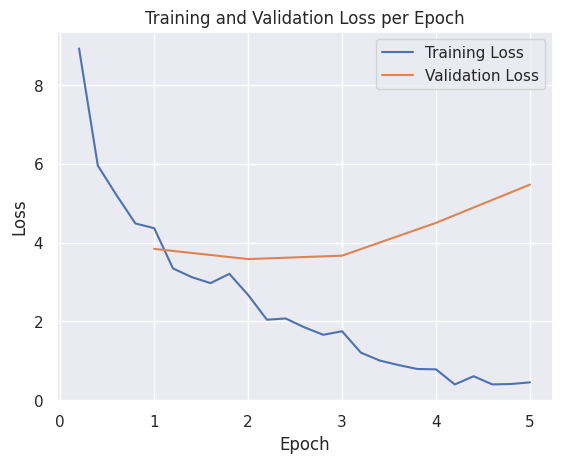

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

This visualization helps in monitoring the training process and making informed decisions about hyperparameters tuning or early stopping.

Training loss measures the error on the data the model was trained on, while validation loss measures the error on a separate dataset the model has not seen before. Monitoring both helps detect overfitting (when the model performs well on training data but poorly on unseen data).

- validation loss >> training loss: **overfitting**
- validation loss > training loss: **some overfitting**
- validation loss < training loss: **some underfitting**
- validation loss << training loss: **underfitting**

## Test Model Inference

After the training is done, you'll want to evaluate and test your model. You can load different samples from the test dataset and evaluate the model on those samples.

For this particular use case, the best model is a matter of preference. Interestingly, what we'd normally call 'overfitting' can be very useful for a game NPC. It forces the model to forget general information and instead lock onto the specific persona and characteristics it was trained on, ensuring it stays consistently in character.


In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = checkpoint_dir

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

ValueError: Unrecognized model in /content/drive/MyDrive/MyGemmaNPC. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: aimv2, aimv2_vision_model, albert, align, altclip, apertus, arcee, aria, aria_text, audio-spectrogram-transformer, autoformer, aya_vision, bamba, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, bitnet, blenderbot, blenderbot-small, blip, blip-2, blip_2_qformer, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, cohere2, cohere2_vision, colpali, colqwen2, conditional_detr, convbert, convnext, convnextv2, cpmant, csm, ctrl, cvt, d_fine, dab-detr, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deepseek_v2, deepseek_v3, deepseek_vl, deepseek_vl_hybrid, deformable_detr, deit, depth_anything, depth_pro, deta, detr, dia, diffllama, dinat, dinov2, dinov2_with_registers, dinov3_convnext, dinov3_vit, distilbert, doge, donut-swin, dots1, dpr, dpt, efficientformer, efficientloftr, efficientnet, electra, emu3, encodec, encoder-decoder, eomt, ernie, ernie4_5, ernie4_5_moe, ernie_m, esm, evolla, exaone4, falcon, falcon_h1, falcon_mamba, fastspeech2_conformer, fastspeech2_conformer_with_hifigan, flaubert, flava, florence2, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, gemma3, gemma3_text, gemma3n, gemma3n_audio, gemma3n_text, gemma3n_vision, git, glm, glm4, glm4_moe, glm4v, glm4v_moe, glm4v_moe_text, glm4v_text, glpn, got_ocr2, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gpt_oss, gptj, gptsan-japanese, granite, granite_speech, granitemoe, granitemoehybrid, granitemoeshared, granitevision, graphormer, grounding-dino, groupvit, helium, hgnet_v2, hiera, hubert, hunyuan_v1_dense, hunyuan_v1_moe, ibert, idefics, idefics2, idefics3, idefics3_vision, ijepa, imagegpt, informer, instructblip, instructblipvideo, internvl, internvl_vision, jamba, janus, jetmoe, jukebox, kosmos-2, kosmos-2.5, kyutai_speech_to_text, layoutlm, layoutlmv2, layoutlmv3, led, levit, lfm2, lightglue, lilt, llama, llama4, llama4_text, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, metaclip_2, mgp-str, mimi, minimax, mistral, mistral3, mixtral, mlcd, mllama, mm-grounding-dino, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, modernbert, modernbert-decoder, moonshine, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmo2, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, ovis2, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, perception_encoder, perception_lm, persimmon, phi, phi3, phi4_multimodal, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prompt_depth_anything, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_5_omni, qwen2_5_vl, qwen2_5_vl_text, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, qwen2_vl_text, qwen3, qwen3_moe, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rt_detr_v2, rwkv, sam, sam2, sam2_hiera_det_model, sam2_video, sam2_vision_model, sam_hq, sam_hq_vision_model, sam_vision_model, seamless_m4t, seamless_m4t_v2, seed_oss, segformer, seggpt, sew, sew-d, shieldgemma2, siglip, siglip2, siglip_vision_model, smollm3, smolvlm, smolvlm_vision, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superglue, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, t5gemma, table-transformer, tapas, textnet, time_series_transformer, timesfm, timesformer, timm_backbone, timm_wrapper, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vitpose, vitpose_backbone, vits, vivit, vjepa2, voxtral, voxtral_encoder, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xcodec, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xlstm, xmod, yolos, yoso, zamba, zamba2, zoedepth

Let's load all questions from the test dataset and generate outputs.

In [15]:
from transformers import pipeline

# Load the model and tokenizer into the pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

def test(test_sample):
  # Convert as test example into a prompt with the Gemma template
  prompt = pipe.tokenizer.apply_chat_template(test_sample["messages"][:1], tokenize=False, add_generation_prompt=True)
  outputs = pipe(prompt, max_new_tokens=256, disable_compile=True)

  # Extract the user query and original answer
  print(f"Question:\n{test_sample['messages'][0]['content']}")
  print(f"Original Answer:\n{test_sample['messages'][1]['content']}")
  print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")
  print("-"*80)

# Test with an unseen dataset
for item in dataset['test']:
  test(item)

Device set to use cuda:0


Question:
Do you know any jokes?
Original Answer:
A joke? k'tak Yez. A Terran, a Glarzon, and a pile of nutrient-pazte walk into a bar... Narg, I forget da rezt. Da punch-line waz zarcaztic.
Generated Answer:
Yez! Yez! Yez! Diz your Krush-tongs iz... k'tak... nice. Why you burn them with acid-flow?
--------------------------------------------------------------------------------
Question:
(Stands idle for too long)
Original Answer:
You'z broken, Terran? Or iz diz... 'meditation'? You look like you're trying to lay an egg.
Generated Answer:
Diz? Diz what you have for me... Zorp iz not for eating you.
--------------------------------------------------------------------------------
Question:
What do you think of my outfit?
Original Answer:
Iz very... pointy. Are you expecting to be attacked by zky-eelz? On Marz, dat would be zenzible.
Generated Answer:
My Zk-Zhip iz... nice. Very... home-baked. You bring me zlight-fruitez?
-------------------------------------------------------------------

If you try our original generalist prompt, you can see that the model still attempts to answer in the trained style. In this example overfitting and catastrophic forgetting are actually beneficial for the game NPC because it will begin forgetting general knowledge which might not be applicable. This is also true for other types of full fine-tuning where the goal is to restrict the output to specific data formats.

In [16]:
outputs = pipe([{"role": "user", "content": "Sorry, you are a game NPC."}], max_new_tokens=256, disable_compile=True)
print(outputs[0]['generated_text'][1]['content'])

Zorp yap-zunit? K'tak... k'tak iz back on da Red-Dust. You... you have shiny bitz?


In [17]:
import base64
import os
from google import genai
from google.genai import types

def generate():
    client = genai.Client(
        #api_key=os.environ.get("GEMINI_API_KEY"),
        api_key=userdata.get('GEMINI_API_KEY'),
    )

    model = "gemini-2.5-flash"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="""Say hello to the class"""),
            ],
        ),
    ]
    tools = [
        types.Tool(googleSearch=types.GoogleSearch(
        )),
    ]
    generate_content_config = types.GenerateContentConfig(
        thinking_config = types.ThinkingConfig(
            thinking_budget=-1,
        ),
        tools=tools,
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        print(chunk.text, end="")
generate()

SecretNotFoundError: Secret GEMINI_API_KEY does not exist.

## Building an LLM-as-Judge Eval Harness

> **Note:**  
Now that we’ve fine-tuned the model to sound more like an alien, the next step is to evaluate it.  
Previously, we used a **test set + script** to check model accuracy (e.g., classifying sports teams).  
But here it’s harder to **programmatically decide** whether a response “sounds alien enough.”  

So instead, we’ll explore building an **LLM-as-a-Judge**:  
- Using clever prompting to have another model score the outputs.  
- Potentially adding **few-shot examples** to guide consistency.  
- We’ll walk through this part **live**, since it’s more open-ended and subjective.  

We’ll build the LLM-as-a-Judge together live, since this kind of evaluation is less straightforward than checking a test set. An “out-of-the-box” judge may not align well with your own sense of what sounds alien. That’s expected:  you’ll usually need to **iterate a few times** and compare against your own human judgments until the judge’s scoring matches what you care about.

## Summary and next steps

In this notebook we fine-tuned **Gemma-270M** on a small, niche dataset of conversations between a player and alien NPCs (Martian and Venusian). The aim was to teach the model to stay in character with a consistent speaking style, demonstrating how even limited data can strongly influence model behavior.

We walked through:  
- Installing dependencies and setting up Hugging Face  
- Preparing and formatting a conversational dataset for fine-tuning  
- Training with Hugging Face TRL’s `SFTTrainer`  
- Monitoring training/validation loss and mean token accuracy  
- Evaluating whether the fine-tuned model maintains persona consistency compared to the base model  

The results showed that with just a small dataset, the model was able to pick up the targeted speaking style and persona, validating the power of fine-tuning for specialized use cases.


This tutorial covered how to full model fine-tune using TRL. Check out the following docs next:

* Learn how to [fine-tune Gemma for text tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_text_finetune_qlora).
* Learn how to [fine-tune Gemma for vision tasks using Hugging Face Transformers](https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora).
* Learn how to [deploy to Cloud Run](https://ai.google.dev/gemma/docs/integrations/google-cloud#run)